#SoC Classification Inference

Preventing disconnect from Google Colab notebook:
Right-click on the connect button and paste the code to the console of the UI:


```
function ClickConnect(){
    console.log("Clicked on connect button");
    document.querySelector("colab-connect-button").click() 
 }
 setInterval(ClickConnect,60000)
```

# Setup

In [5]:
%pip install fastai==2.5.3 -q
%pip freeze

absl-py==1.1.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.2
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.7.7
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.7
certifi==2022.6.15
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.5
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.30
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.5.1
distribu

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision.all import *
import sys

In [7]:
# Load EB_ML python libraries
# The following libraries are used in this notebook and should be installed in your local machine before running this notebook.
# eb_colab_utils.py
# eb_ml_battery_lib.py
# eb_ml_utils.py

# path to load external *.py files used in this notebook
# Note: in Google Colab virtual machine you shoud copy the files in "/content" folder after BEFORE running this notebook's cell

external_python_file_path="/content"
sys.path.append(external_python_file_path)

In [8]:
from eb_ml_utils import build_data_loader,score_model
from eb_ml_colab_utils import get_root_path
from eb_ml_battery_lib import load_soc_dataset,generate_image_files_from_eis

# Experiment configuration 

In [9]:
#configuration dictionary
config ={}

# Root working folder (local or Google Drive)
# config['ROOT_DIR'] = get_root_path("batterie")
config['ROOT_DIR'] = get_root_path("batterie")  

# Folder with dataset in CSV format
#config['DATASETS_DIR'] = config['ROOT_DIR']+"/datasets"
config['DATASETS_DIR'] = config['ROOT_DIR']+"/datasets/EIS-vs-SOC-May2022"

# List of SoC level into dataset
config['soc_list']=['100','090','080','070','060','050','040','030','020','010']

# Folder to store trained model
#config['MODELS_DIR'] = config['ROOT_DIR']+"/models"
config['MODELS_DIR'] = config['ROOT_DIR']+"/models"

#TODO: nel dataset di validazione alcune classi non sono rappresentate. Usare stratified splitter
config['Splitter'] = RandomSplitter(valid_pct=0.3, seed=41)
config['rePat'] = r'^.*_(\d+).png$'


#Acquisizioni dati caricare per inferenza con modello addestrato
test_battery_list=[[6],[13],[14]]

Running on COLAB
Mounted at /gdrive


## Image file generation for inference

In [10]:
# Enable/disable image dataset generation
# Image generation process consume time and computational resources. 
# You need to generate image just once test EIS data acquisition
# generate_images = False
generate_images = False

# List EIS data acquistion that need image generation
#image_dataset_to_be_generated=[6,13,14]
image_dataset_to_be_generated=['05_8']

#GENERATE IMAGE
if(generate_images):
  for batt in image_dataset_to_be_generated:
    config['ExperimentName']= "BATTERY_"+str(batt)
    config['TEST_IMAGES_PATH']= config['ROOT_DIR']+"/ForumMisure_TEST_DATA"
    test_dataset,feature_col_names=load_soc_dataset([batt],config["soc_list"],config['DATASETS_DIR'])
    generate_image_files_from_eis(test_dataset,feature_col_names,config['TEST_IMAGES_PATH'],config['ExperimentName'],DATA_AUGMENTATION_FACTOR=1)

# Model Ensamble

Inference with model ensamble on Test Data 

Source data: battery EIS performed for SoC 100,90,80,70,60,50,40,30,20,10. Same frequnecies for each SoC

Data format:  Re{Zbat}-Im{Zbat}j

Data Acquisition:

1. Batt1/Meas1
2. Batt1/Meas2
3. Batt2/Meas1 
4. Batt2/Meas2
5. Batt3/Meas1
6. Batt3/Meas2 --> TEST
7. Batt4/Meas1
8. Batt5/Meas1
9. Batt6/Meas1 
10. Batt7/Meas1
11. Batt8/Meas1
12. Batt9/Meas1
13. Batt10/Meas1 -->TEST
14. Batt4/Meas2 -->TEST







In [11]:
experiments=['Paper_EIS_leave_one_out_02','Paper_EIS_leave_one_out_03','Paper_EIS_leave_one_out_05'] 
saved_weights_files= ['/gdrive/MyDrive/batterie/models/Paper_EIS_leave_one_out_02_1655886753.791071_SAVED',
                      '/gdrive/MyDrive/batterie/models/Paper_EIS_leave_one_out_03_1655887522.925985_SAVED',
                      '/gdrive/MyDrive/batterie/models/Paper_EIS_leave_one_out_05_1655888240.895227_SAVED'
                      ]


## Inference on new data acquisition on battery 6

In [12]:
experiments_predictions = []
experiments_predictions_decoded=[]

exeperiments_targets = []

models_accuracy = []

models_top2_accuracy = []

config['TEST_IMAGES_PATH']= config['ROOT_DIR']+"/ForumMisure_TEST_DATA/BATTERY_06_8/"
test_fnames= get_image_files(config["TEST_IMAGES_PATH"])
for experiment_index in range(0,len(experiments),1):
  print("ExperimentName: "+str(experiments[experiment_index]))
  saved_weights=saved_weights_files[experiment_index]
  config['ExperimentName'] = experiments[experiment_index]
  config['IMAGES_PATH'] = config['ROOT_DIR']+"/"+config['ExperimentName']

  # BUILD DATA LOADER
  dl=build_data_loader(config)

  # BUILD LEARNER
  learn = cnn_learner(dl, resnet18, metrics=accuracy)

  learn = learn.load(saved_weights)

  # SCORE MODEL
  #score_model(saved_weights,dl)

  
  test_dl = learn.dls.test_dl(test_fnames,with_labels=True)
  predictions, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
  experiments_predictions.append(predictions)
  experiments_predictions_decoded.append(decoded)
  exeperiments_targets.append(targets)
  model_accuracy= accuracy(predictions,targets)
  models_accuracy.append(model_accuracy)
  from sklearn.metrics import top_k_accuracy_score
  model_top2_accuracy= top_k_accuracy_score(targets, predictions, k=2)
  models_top2_accuracy.append(model_top2_accuracy)
  print("model_accuracy: " + str(model_accuracy))
  print("model_top2_accuracy: " + str(model_top2_accuracy))

ExperimentName: Paper_EIS_leave_one_out_02
Setting-up type transforms pipelines
Found 1020 items
2 datasets of sizes 714,306
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_02/Paper_EIS_leave_one_out_02/EIS_BATT05_5_040.png
    applying PILBase.create gives
      PILImage mode=RGB size=432x288
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_02/Paper_EIS_leave_one_out_02/EIS_BATT05_5_040.png
    applying RegexLabeller gives
      040
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=432x288, TensorCategory(3))


Found 1020 items
2 datasets of sizes 714,306
Setting up Pipeline: P

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

model_accuracy: TensorBase(0.6700)
model_top2_accuracy: 0.87
ExperimentName: Paper_EIS_leave_one_out_03
Setting-up type transforms pipelines
Found 1020 items
2 datasets of sizes 714,306
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_03/Paper_EIS_leave_one_out_03/EIS_BATT05_5_040.png
    applying PILBase.create gives
      PILImage mode=RGB size=432x288
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_03/Paper_EIS_leave_one_out_03/EIS_BATT05_5_040.png
    applying RegexLabeller gives
      040
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=432x288, TensorCategory(3))


Found 

model_accuracy: TensorBase(0.6300)
model_top2_accuracy: 0.89
ExperimentName: Paper_EIS_leave_one_out_05
Setting-up type transforms pipelines
Found 1040 items
2 datasets of sizes 728,312
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_05/Paper_EIS_leave_one_out_05/EIS_BATT1835_050.png
    applying PILBase.create gives
      PILImage mode=RGB size=432x288
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_05/Paper_EIS_leave_one_out_05/EIS_BATT1835_050.png
    applying RegexLabeller gives
      050
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(4)

Final sample: (PILImage mode=RGB size=432x288, TensorCategory(4))


Found 

model_accuracy: TensorBase(0.5000)
model_top2_accuracy: 0.76


In [13]:
models_accuracy

[TensorBase(0.6700), TensorBase(0.6300), TensorBase(0.5000)]

In [14]:
np.mean(models_accuracy)

0.59999996

In [15]:
models_top2_accuracy

[0.87, 0.89, 0.76]

In [16]:
np.mean(models_top2_accuracy)

0.84

In [17]:
# Calculate ensable prediction
ensamble_prediction = experiments_predictions[0]
for pred in experiments_predictions[1:]:
  ensamble_prediction += pred

ensamble_prediction /= len(experiments_predictions)
#ensamble_accuracy
accuracy(ensamble_prediction, exeperiments_targets[0])

TensorBase(0.6200)

## New measurement test case: Inference on new data acquisition on battery 5 (EIS Data acquisition 5_8: battery 05 measurement 8)

In [18]:
experiments_predictions = []

exeperiments_targets = []

models_accuracy = []

models_top2_accuracy = []

config['TEST_IMAGES_PATH']= config['ROOT_DIR']+"/ForumMisure_TEST_DATA/BATTERY_05_8/"
test_fnames= get_image_files(config["TEST_IMAGES_PATH"])
for experiment_index in range(0,len(experiments),1):
  print("ExperimentName: "+str(experiments[experiment_index]))
  saved_weights=saved_weights_files[experiment_index]
  config['ExperimentName'] = experiments[experiment_index]
  config['IMAGES_PATH'] = config['ROOT_DIR']+"/"+config['ExperimentName']

  # BUILD DATA LOADER
  dl=build_data_loader(config)

  # BUILD LEARNER
  learn = cnn_learner(dl, resnet18, metrics=accuracy)

  learn = learn.load(saved_weights)

  # SCORE MODEL
  #score_model(saved_weights,dl)

  
  test_dl = learn.dls.test_dl(test_fnames,with_labels=True)
  predictions, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
  experiments_predictions.append(predictions)
  exeperiments_targets.append(targets)
  model_accuracy= accuracy(predictions,targets)
  models_accuracy.append(model_accuracy)
  from sklearn.metrics import top_k_accuracy_score
  model_top2_accuracy= top_k_accuracy_score(targets, predictions, k=2)
  models_top2_accuracy.append(model_top2_accuracy)
  print("model_accuracy: " + str(model_accuracy))
  print("model_top2_accuracy: " + str(model_top2_accuracy))

ExperimentName: Paper_EIS_leave_one_out_02
Setting-up type transforms pipelines
Found 1020 items
2 datasets of sizes 714,306
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_02/Paper_EIS_leave_one_out_02/EIS_BATT05_5_040.png
    applying PILBase.create gives
      PILImage mode=RGB size=432x288
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_02/Paper_EIS_leave_one_out_02/EIS_BATT05_5_040.png
    applying RegexLabeller gives
      040
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=432x288, TensorCategory(3))


Found 1020 items
2 datasets of sizes 714,306
Setting up Pipeline: P

model_accuracy: TensorBase(0.8000)
model_top2_accuracy: 1.0
ExperimentName: Paper_EIS_leave_one_out_03
Setting-up type transforms pipelines
Found 1020 items
2 datasets of sizes 714,306
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_03/Paper_EIS_leave_one_out_03/EIS_BATT05_5_040.png
    applying PILBase.create gives
      PILImage mode=RGB size=432x288
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_03/Paper_EIS_leave_one_out_03/EIS_BATT05_5_040.png
    applying RegexLabeller gives
      040
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=432x288, TensorCategory(3))


Found 1

model_accuracy: TensorBase(1.)
model_top2_accuracy: 1.0
ExperimentName: Paper_EIS_leave_one_out_05
Setting-up type transforms pipelines
Found 1040 items
2 datasets of sizes 728,312
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_05/Paper_EIS_leave_one_out_05/EIS_BATT1835_050.png
    applying PILBase.create gives
      PILImage mode=RGB size=432x288
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_05/Paper_EIS_leave_one_out_05/EIS_BATT1835_050.png
    applying RegexLabeller gives
      050
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(4)

Final sample: (PILImage mode=RGB size=432x288, TensorCategory(4))


Found 1040 

model_accuracy: TensorBase(0.5000)
model_top2_accuracy: 0.6


In [19]:
models_accuracy

[TensorBase(0.8000), TensorBase(1.), TensorBase(0.5000)]

In [20]:
np.mean(models_accuracy)

0.76666665

In [21]:
models_top2_accuracy

[1.0, 1.0, 0.6]

In [22]:
np.mean(models_top2_accuracy)

0.8666666666666667

In [23]:
# Calculate ensable prediction
ensamble_prediction = experiments_predictions[0]
for pred in experiments_predictions[1:]:
  ensamble_prediction += pred

ensamble_prediction /= len(experiments_predictions)
#ensamble_accuracy
accuracy(ensamble_prediction, exeperiments_targets[0])

TensorBase(0.9000)

In [24]:
#ensamble top2 accuracy
top_k_accuracy_score(exeperiments_targets[0], ensamble_prediction, k=2)

1.0

## New battery test case: Inference on new data acquisition on battery 6 (EIS Data acquisition 6_5: battery 06 measurement 5)

In [45]:
experiments_predictions = []

exeperiments_targets = []

models_accuracy = []

models_top2_accuracy = []

config['TEST_IMAGES_PATH']= config['ROOT_DIR']+"/ForumMisure_TEST_DATA/BATTERY_06_4/"
test_fnames= get_image_files(config["TEST_IMAGES_PATH"])
for experiment_index in range(0,len(experiments),1):
  print("ExperimentName: "+str(experiments[experiment_index]))
  saved_weights=saved_weights_files[experiment_index]
  config['ExperimentName'] = experiments[experiment_index]
  config['IMAGES_PATH'] = config['ROOT_DIR']+"/"+config['ExperimentName']

  # BUILD DATA LOADER
  dl=build_data_loader(config)

  # BUILD LEARNER
  learn = cnn_learner(dl, resnet18, metrics=accuracy)

  learn = learn.load(saved_weights)

  # SCORE MODEL
  #score_model(saved_weights,dl)

  
  test_dl = learn.dls.test_dl(test_fnames,with_labels=True)
  predictions, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
  experiments_predictions.append(predictions)
  exeperiments_targets.append(targets)
  model_accuracy= accuracy(predictions,targets)
  models_accuracy.append(model_accuracy)
  from sklearn.metrics import top_k_accuracy_score
  model_top2_accuracy= top_k_accuracy_score(targets, predictions, k=2)
  models_top2_accuracy.append(model_top2_accuracy)
  print("model_accuracy: " + str(model_accuracy))
  print("model_top2_accuracy: " + str(model_top2_accuracy))

ExperimentName: Paper_EIS_leave_one_out_02
Setting-up type transforms pipelines
Found 1020 items
2 datasets of sizes 714,306
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_02/Paper_EIS_leave_one_out_02/EIS_BATT05_5_040.png
    applying PILBase.create gives
      PILImage mode=RGB size=432x288
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_02/Paper_EIS_leave_one_out_02/EIS_BATT05_5_040.png
    applying RegexLabeller gives
      040
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=432x288, TensorCategory(3))


Found 1020 items
2 datasets of sizes 714,306
Setting up Pipeline: P

model_accuracy: TensorBase(0.9500)
model_top2_accuracy: 0.99
ExperimentName: Paper_EIS_leave_one_out_03
Setting-up type transforms pipelines
Found 1020 items
2 datasets of sizes 714,306
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_03/Paper_EIS_leave_one_out_03/EIS_BATT05_5_040.png
    applying PILBase.create gives
      PILImage mode=RGB size=432x288
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_03/Paper_EIS_leave_one_out_03/EIS_BATT05_5_040.png
    applying RegexLabeller gives
      040
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=432x288, TensorCategory(3))


Found 

model_accuracy: TensorBase(0.9600)
model_top2_accuracy: 0.99
ExperimentName: Paper_EIS_leave_one_out_05
Setting-up type transforms pipelines
Found 1040 items
2 datasets of sizes 728,312
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_05/Paper_EIS_leave_one_out_05/EIS_BATT1835_050.png
    applying PILBase.create gives
      PILImage mode=RGB size=432x288
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_leave_one_out_05/Paper_EIS_leave_one_out_05/EIS_BATT1835_050.png
    applying RegexLabeller gives
      050
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(4)

Final sample: (PILImage mode=RGB size=432x288, TensorCategory(4))


Found 

model_accuracy: TensorBase(0.6200)
model_top2_accuracy: 0.8


In [26]:
models_accuracy

[TensorBase(0.8700), TensorBase(0.8200), TensorBase(0.5400)]

In [27]:
np.mean(models_accuracy)

0.74333334

In [28]:
models_top2_accuracy

[0.98, 0.96, 0.77]

In [29]:
np.mean(models_top2_accuracy)

0.9033333333333333

In [30]:
# Calculate ensable prediction
ensamble_prediction = experiments_predictions[0]
for pred in experiments_predictions[1:]:
  ensamble_prediction += pred

ensamble_prediction /= len(experiments_predictions)
#ensamble_accuracy
accuracy(ensamble_prediction, exeperiments_targets[0])

TensorBase(0.8000)

In [31]:
#ensamble top2 accuracy
top_k_accuracy_score(exeperiments_targets[0], ensamble_prediction, k=2)

0.95

# Single Model - Training/Validation split

Modello addestrato con tutti i dati tranne batteria 3 e 10

In [32]:
#model trained on data acquisition from batteries 1,2,4,5,6,7,8,9
# acquistion from batteries 3 and 10 used only for inference test
saved_weights = "/gdrive/MyDrive/batterie/models/Paper_EIS_single_model_BATT-2-3-5_1655745145.09554_SAVED"

config['ExperimentName'] = "Paper_EIS_single_model_BATT-2-3-5"
config['IMAGES_PATH'] = config['ROOT_DIR']+"/"+config['ExperimentName']

## Test on new data acquisition on battery 5 (measurement 8)

In [33]:
config['TEST_IMAGES_PATH']= config['ROOT_DIR']+"/ForumMisure_TEST_DATA/BATTERY_05_8/"
test_fnames= get_image_files(config["TEST_IMAGES_PATH"])
#DATA LOADER
dl=build_data_loader(config)

# BUILD LEARNER
learn = cnn_learner(dl, resnet18, metrics=accuracy)

learn = learn.load(saved_weights)

test_dl = learn.dls.test_dl(test_fnames,with_labels=True)
predictions, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
model_accuracy= accuracy(predictions,targets)
from sklearn.metrics import top_k_accuracy_score
model_top2_accuracy= top_k_accuracy_score(targets, predictions, k=2)
print("model_accuracy: " + str(model_accuracy))
print("model_top2_accuracy: " + str(model_top2_accuracy))

Setting-up type transforms pipelines
Found 1140 items
2 datasets of sizes 798,342
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_single_model_BATT-2-3-5/Paper_EIS_single_model_BATT-2-3-5/EIS_BATT1988_020.png
    applying PILBase.create gives
      PILImage mode=RGB size=432x288
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_single_model_BATT-2-3-5/Paper_EIS_single_model_BATT-2-3-5/EIS_BATT1988_020.png
    applying RegexLabeller gives
      020
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=432x288, TensorCategory(1))


Found 1140 items
2 datasets of sizes 798,342
Setting up Pipeline: PILBase.create
S

model_accuracy: TensorBase(0.9000)
model_top2_accuracy: 1.0


[[42  0  0  0  0  0  0  0  0  0]
 [ 0 39  2  0  0  0  0  0  0  0]
 [ 0  1 25  3  1  0  0  0  0  0]
 [ 0  0  2 20  0  0  0  0  0  0]
 [ 0  0  0  3 31  0  0  0  0  0]
 [ 0  0  0  0  0 35  0  0  0  0]
 [ 0  0  0  0  0  0 41  2  0  0]
 [ 0  0  0  0  0  0  3 28  0  0]
 [ 0  0  0  0  0  0  0  2 27  0]
 [ 0  0  4  0  0  0  0  0  0 31]]
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.95121951 0.04878049 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.03333333 0.83333333 0.1        0.03333333 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.09090909 0.90909091 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.08823529 0.91176471 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0. 

learn.validate()


Model accuracy: 0.93
learn.get_preds()


TensorBase(0.9327)

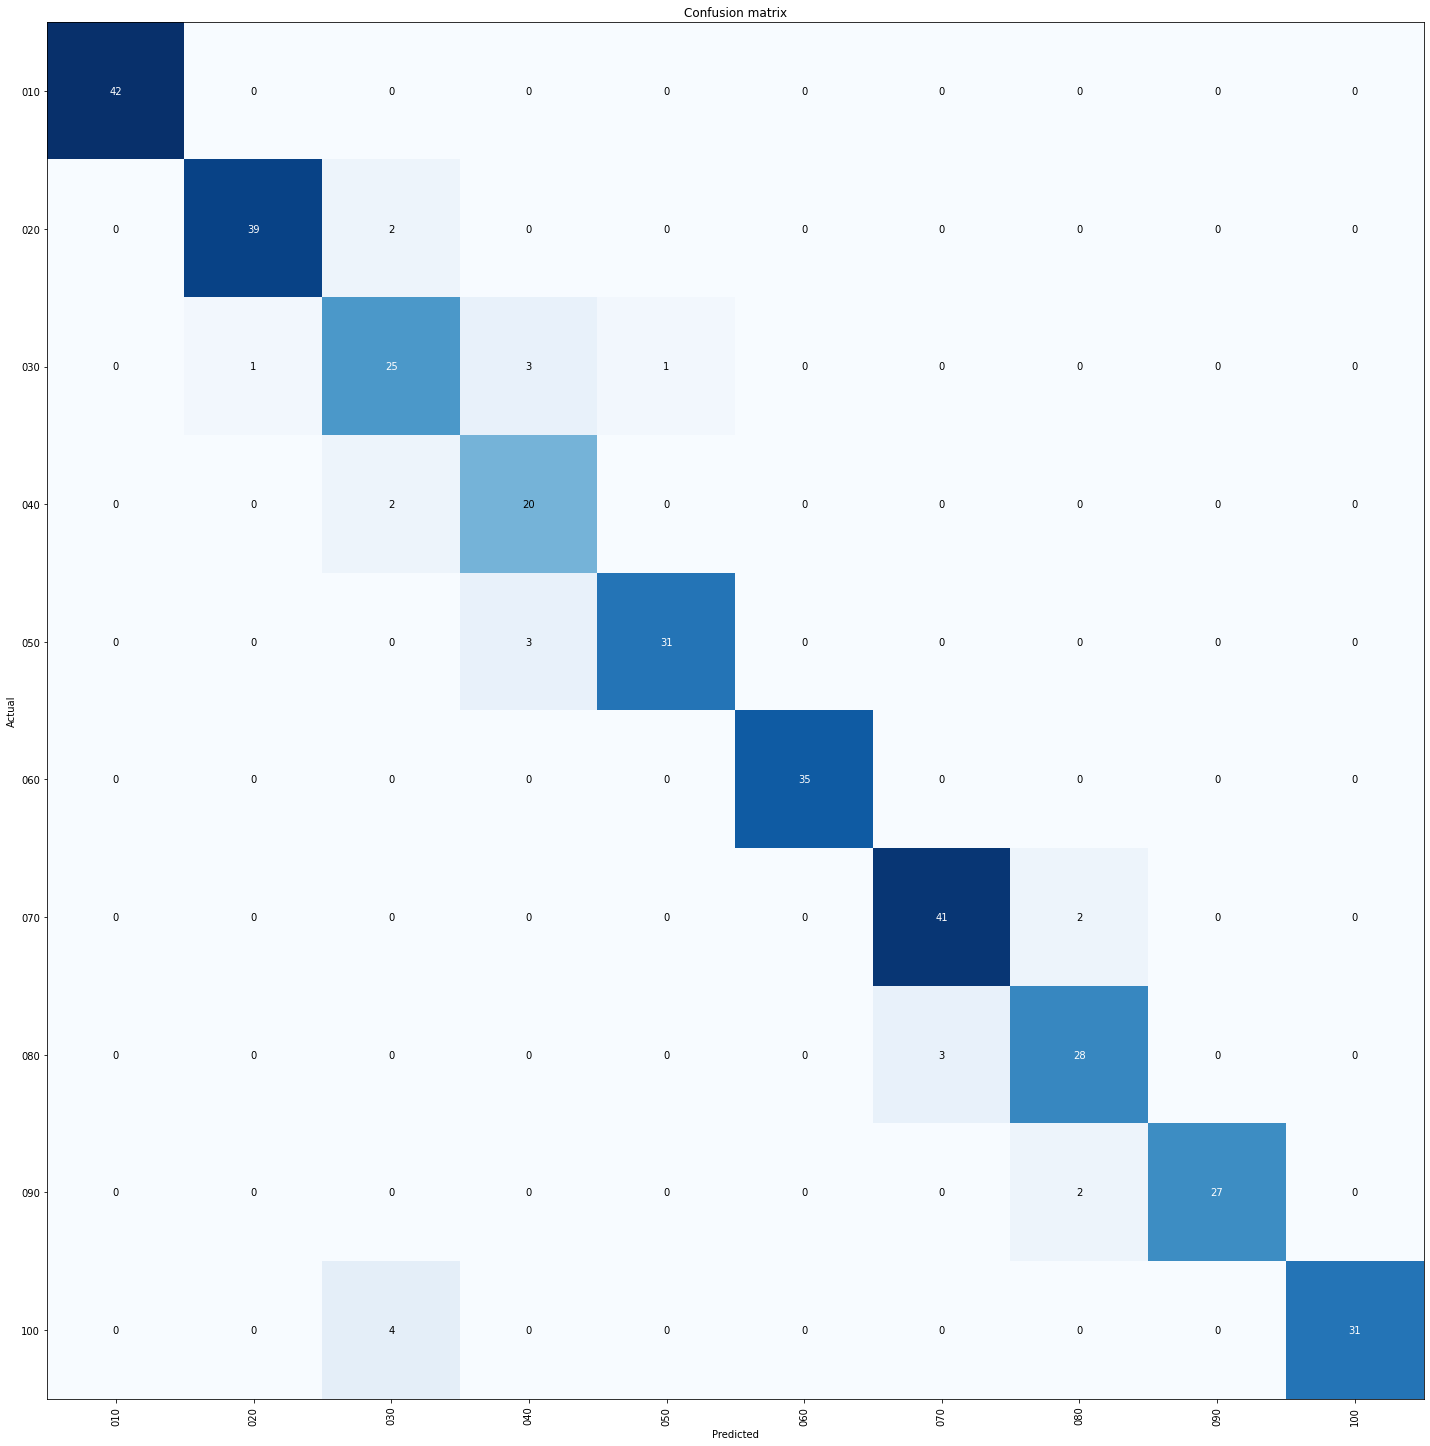

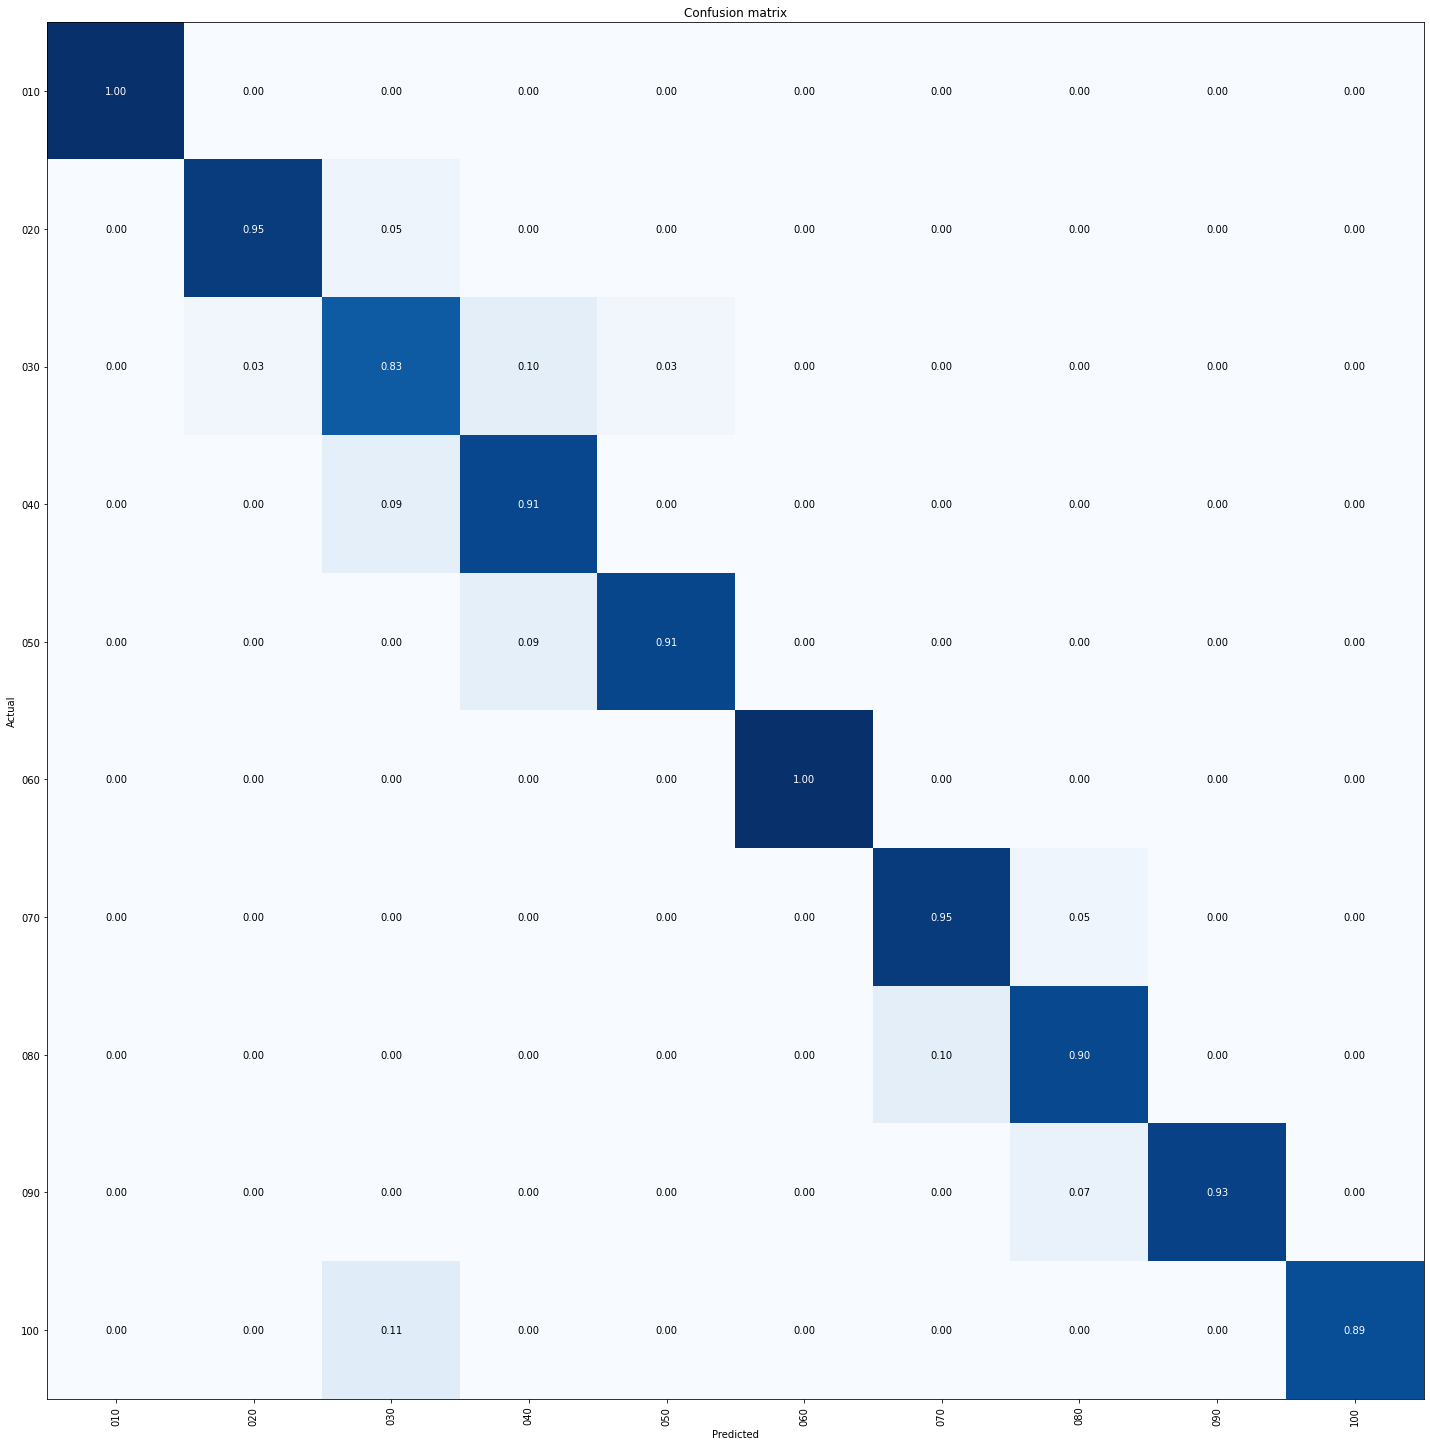

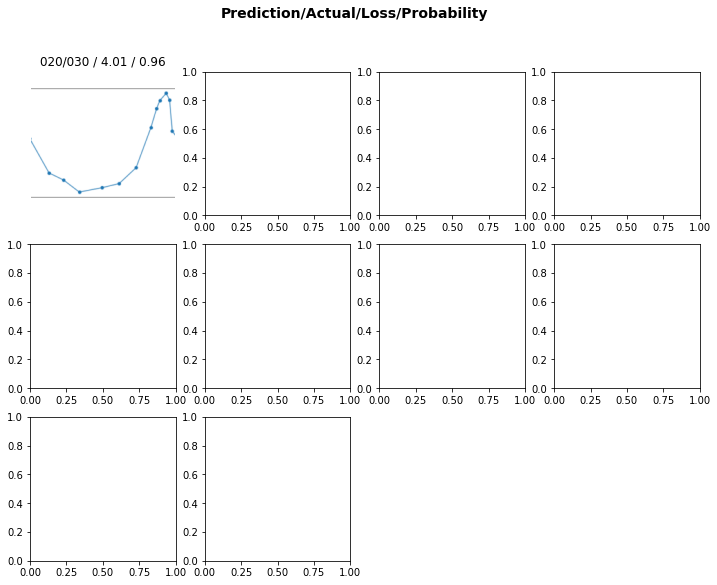

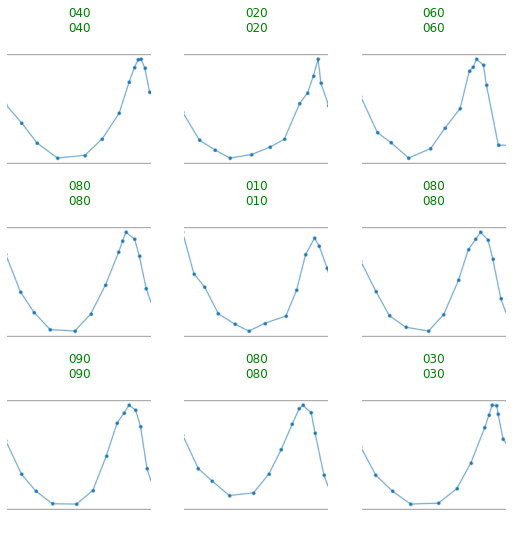

In [34]:
# SCORE MODEL
score_model(saved_weights,dl)

## Test on new battery (battery 6)

In [39]:
config['TEST_IMAGES_PATH']= config['ROOT_DIR']+"/ForumMisure_TEST_DATA/BATTERY_06_5/"
test_fnames= get_image_files(config["TEST_IMAGES_PATH"])
#DATA LOADER
dl=build_data_loader(config)

# BUILD LEARNER
learn = cnn_learner(dl, resnet18, metrics=accuracy)

learn = learn.load(saved_weights)

test_dl = learn.dls.test_dl(test_fnames,with_labels=True)
predictions, targets, decoded = learn.get_preds(dl=test_dl, with_decoded=True)
model_accuracy= accuracy(predictions,targets)
from sklearn.metrics import top_k_accuracy_score
model_top2_accuracy= top_k_accuracy_score(targets, predictions, k=2)
print("model_accuracy: " + str(model_accuracy))
print("model_top2_accuracy: " + str(model_top2_accuracy))

Setting-up type transforms pipelines
Found 1140 items
2 datasets of sizes 798,342
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_single_model_BATT-2-3-5/Paper_EIS_single_model_BATT-2-3-5/EIS_BATT1988_020.png
    applying PILBase.create gives
      PILImage mode=RGB size=432x288
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /gdrive/MyDrive/batterie/Paper_EIS_single_model_BATT-2-3-5/Paper_EIS_single_model_BATT-2-3-5/EIS_BATT1988_020.png
    applying RegexLabeller gives
      020
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=432x288, TensorCategory(1))


Found 1140 items
2 datasets of sizes 798,342
Setting up Pipeline: PILBase.create
S

model_accuracy: TensorBase(0.8800)
model_top2_accuracy: 0.96
